# Missing Data Treatment: A Hand-on Illustration using `R` Package `mice`

<img src="./Figures/cat-mouse.jpg" style="width:100%">

## 0. Overview

### 0.1 Learning Intention
This learning session aims to empower the `R` user community with a gentle introduction to the multiple imputation (MI) procedure in order to address missing data problems using one widely used `R` package: multivariate imputation by chained equations (`mice`, van Buuren & Groothuis-Oudshoorn, 2011).

### 0.2 Success Criteria
At the end of this session, participants would gain *interest* and *confidence* in dealing with missing data in their work.

Learners would be, firstly, able to assess the missing data mechanism in their datasets and apply appropriate treatment procedures accordingly. Additionally, they can appreciate the workflow of the `mice` package and see how Rubin's rule is applied to the pulling process. Finally, learners are able to interpret `mice` output in order to answer their research questions.

Furthermore, participants would continue their learning by reaching out to advanced MI literature for techniques suitable for their specific modelling needs.

### 0.3 Learning Structure
[//todo Insert table of content here]

## 1. Background

### 1.1 Rationale for Multiple Imputation
Complete-case analyses are only valid and unbiased under very restricted conditions (MCAR, defined below). Even when such condition holds, removing cases would cause huge loss in estimation efficiency. In addition, all resources and efforts may go to waste due to one single impurity in an observation. Multiple imputation tries to salvage imperfections by filling the "holes" with "guesses". The uncertainty of our guesses is reflected in the variation of the imputed values--the wider the variation, the less certain we are about our guesses.

### 1.2 Two Approaches to Missing Data Treatment
**Joint modelling** (JM, Schafter (1997); `R` package `jomo`) and **fully conditional specification** (FCS) are the two main approaches to missing data treatment. FCS is also known as multivariate imputation by chained equations (MICE). This session will focus exclusively on the `R` package `mice` by van Buuren and Groothuis-Oudshoorn (2011), currently in Version 3.14.0, to demonstrate the power and flexibility of the MICE procedure for handling missing data. Other `R` packages that work with missing data are `Amelia`, `Hmisc`, `jomo`, `mi`, `norm`, `norm2` and `pan`. See Table 5.1 of Kleinke et al. (2020) for a comparison of these packages. Table 6 of Grund et al. (2018) provides specific advice on package uses for multilevel models.

## 2. Data Missing Mechanism (Rubin, 1976)

<img src="./Figures/mechanism.png" style="width:100%">

### 2.1 Missing Completely at Random (**MCAR**)

A variable's missing propensity is *independent* of all variables in the dataset.

This is the "least evil" case of missings. Under MCAR, complete-case analyses are still valid and estimates unbiased--although efficiency is reduced due to smaller dataset.

### 2.2 Missing at Random (**MAR**)

A variable's missing propensity depends *exclusively* on the *observed* variables.

The MAR assumption is behind most MI procedures, including `mice`.

### 2.3 Missing not at Random (**MNAR**)

A variable's missing propensity depends on *unobserved* variables.

MNAR represents the "most evil" end of the spectrum. The exact theory and treatment of MNAR is complicated. Interested readers are referred to Rose's (2013) thesis for richer references. In practice, we can introduce lots of covariates to the MI process in order to push MNAR more towards the MAR region of the spectrum.

### 2.4 Ignorability
The missing data literature commonly refers to MCAR and MAR as "ignorable missings" while to MNAR as "non-ignorable missings". Such vocabulary does *not* suggest no treatment is required, however, but whether subsequent analyses interact with the data missing process.

## 3. The `mice` Package

### 3.1 `mice` Workflow

<img src="./Figures/workflow.jpg" style="width:100%">

### 3.2 First Look at `mice`

In [1]:
# Install some packages if not yet done so
# install.packages(c("mice","VIM"),dependencies = T)

# Set working directory
library(Orcs)
setwdOS(lin = "~/uio", win = "M:/", ext = "pc/Dokumenter/PhD/Teaching/UseR/Missing_Data/")

# Load the mice package (suppress both warnings and messages)
suppressWarnings(suppressMessages(
    library(mice)
))

# Use the example dataset nhanes (came with the package)
nhanes

# observations = 25, variables = 4
# Variable names
#    age     age group               ordered categorical
#    bmi     body mass index         numerical
#    hyp     hypertension status     binary
#    chl     cholesterol level       numerical

Loading required package: raster

Loading required package: sp



,age,bmi,hyp,chl
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,NA,NA,NA
2,2,22.7,1,187
3,1,NA,1,187
4,3,NA,NA,NA
5,1,20.4,1,113
6,3,NA,NA,184
7,1,22.5,1,118
8,1,30.1,1,187
9,2,22.0,1,238


### 3.3 Missing Pattern Inspection

There are two ways we can inspect missing data patterns: a "macro" inspection looks at the whole dataset whereas the "micro" inspections examine each variable pairs:

,age,hyp,bmi,chl,
13,1,1,1,1,0
3,1,1,1,0,1
1,1,1,0,1,1
1,1,0,0,1,2
7,1,0,0,0,3
,0,8,9,10,27


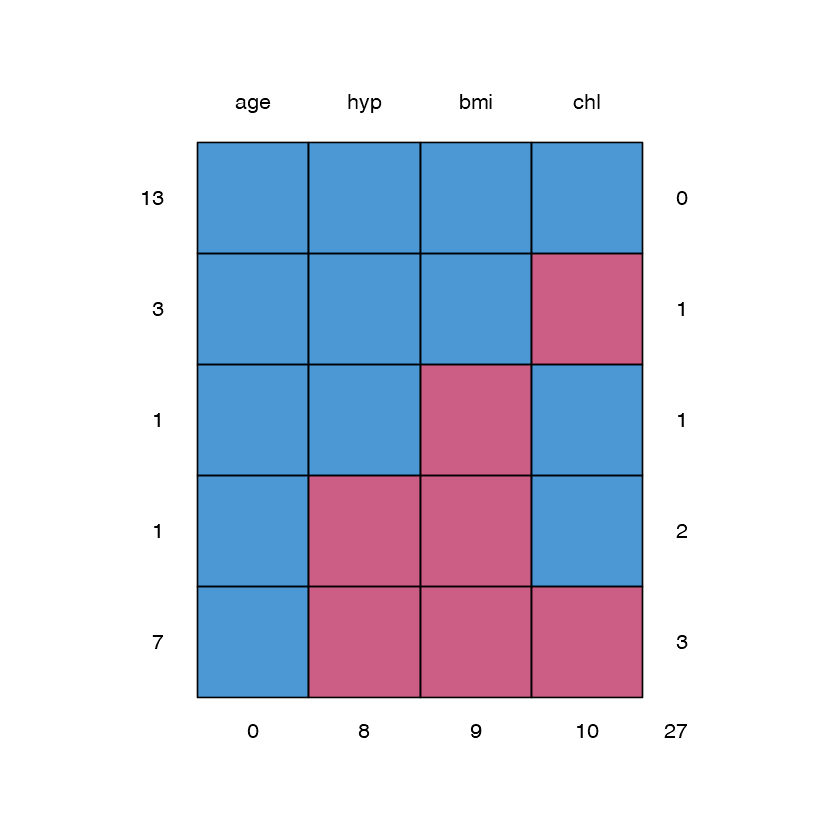

In [2]:
# Inspect missing pattern (Method 1)
md.pattern(nhanes)

# Colour convention
#   blue    observed
#   red     missing
# Interpretation
#   13 rows are complete
#   3 row that chl is missing
#   1 row that bmi is missing
#   1 row that both hyp and bmi are missing
#   7 rows that only age is observed
#   Total number of missing values = 3x1 + 1x1 + 1x2 + 7x3 = 27
#   Most missing values (10) occur in chl

In [3]:
# Inspection by variable pairs (Method 2)
md.pairs(nhanes)

# Symbol convention (left, top)
#   r   observed (remain?)
#   m   missing

# Interpretation (focus on (bmi, chl) pair)
#   13 completely observed paris
#   3 pairs: bmi is observed but chl is missing
#   2 pairs: bmi is missing but chl is observed
#   7 pairs: both bmi and chl are missing

,age,bmi,hyp,chl
age,25,16,17,15
bmi,16,16,16,13
hyp,17,16,17,14
chl,15,13,14,15
,age,bmi,hyp,chl
age,0,9,8,10
bmi,0,0,0,3
hyp,0,1,0,3
chl,0,2,1,0
,age,bmi,hyp,chl


### 3.4 Margin Plot

A very helpful way to visualise missing data pattern is through a margin plot for each variable pair, generated by the `VIM` package:

[1] 113 284

[1] 20.4 35.3

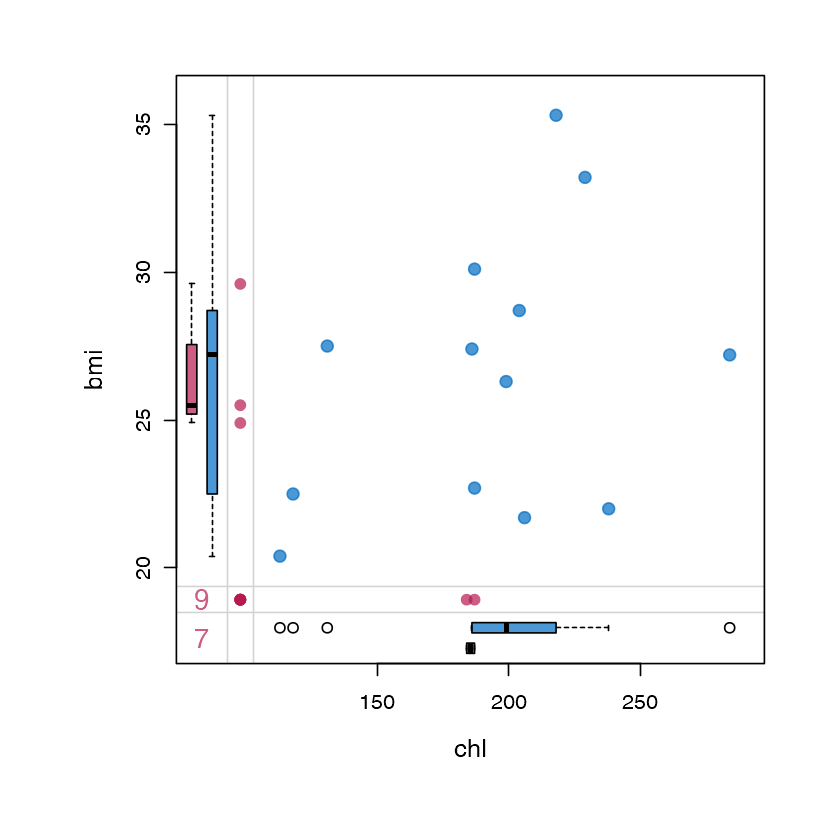

In [4]:
# Margin plot
par(mar = c(7, 7, 3, 3)) # In order to show the axes labels
# Inspect data range
c(min(nhanes$chl, na.rm = T), max(nhanes$chl, na.rm = T)) # (113, 284)
c(min(nhanes$bmi, na.rm = T), max(nhanes$bmi, na.rm = T)) # (20.4, 35.3)
# Generate margin plot
VIM::marginplot(nhanes[, c("chl", "bmi")],
    xlim = c(110, 290), ylim=c(20, 36),
    col = mdc(1:2), pch = 19,
    cex = 1.2, cex.lab = 1.2, cex.numbers = 1.3
)

# Interpretation
#   red 9   variable bmi contains 9 missings
#   red 10  variable chl contains 10 missings
#   red 7   The variable pair (bmi, chl) contains 7 missings
#   three red dots on the left: bmi values are known but chl missing
#   two red dots on the bottom: chl values are known but bmi missing
#   red dot cross between bmi and chl actually represents 7 dots
#   Total # dots = 13 (blue) + 3 (red left) + 2 (red bottom) + 7 (red cross)
#   Box plots: marginal distributions (blue = obs, red = mis)
#   If MCAR => red and blue box plots are expected to be identical

### 3.5 Impute Missing Data

We can now generate our first imputation using `mice`, accepting all default settings:

In [5]:
imp <- mice(nhanes, printFlag = F, seed = 23109)
# The multiply imputed dataset, imp, is of class mids (MI data set)
print(imp)

Class: mids
Number of multiple imputations:  5 
Imputation methods:
  age   bmi   hyp   chl 
   "" "pmm" "pmm" "pmm" 
PredictorMatrix:
    age bmi hyp chl
age   0   1   1   1
bmi   1   0   1   1
hyp   1   1   0   1
chl   1   1   1   0


### 3.6 Diagnostic Checking

It is important to check that the imputed data indeed make sense:

In [6]:
# Recall that bmi contains 9 missings
# The MI procedure produced five guesses for each missing:
imp$imp$bmi

,1,2,3,4,5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,27.2,27.2,29.6,27.4,20.4
3,27.2,27.2,29.6,35.3,27.2
4,24.9,25.5,25.5,20.4,22.0
6,21.7,21.7,20.4,27.4,25.5
10,22.5,22.5,22.5,33.2,26.3
11,29.6,27.2,27.2,35.3,33.2
12,22.0,25.5,27.2,30.1,28.7
16,35.3,27.2,35.3,29.6,27.2
21,28.7,25.5,22.5,33.2,20.4


In [7]:
# The 1st complete dataset combines the observed and imputed values:
complete(imp)

,age,bmi,hyp,chl
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,27.2,1,238
2,2,22.7,1,187
3,1,27.2,1,187
4,3,24.9,1,184
5,1,20.4,1,113
6,3,21.7,2,184
7,1,22.5,1,118
8,1,30.1,1,187
9,2,22.0,1,238


In [8]:
# We can print out the 2nd set of the complete dataset
complete(imp, 2)

# If complete to start with => identical in all five sets
# If missing to start with => differ in each set
# Degree of difference reflects degree of uncertainty

,age,bmi,hyp,chl
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,27.2,1,187
2,2,22.7,1,187
3,1,27.2,1,187
4,3,25.5,2,186
5,1,20.4,1,113
6,3,21.7,2,184
7,1,22.5,1,118
8,1,30.1,1,187
9,2,22.0,1,238


### 3.7 MI Visual Inspection

Similar to Section 3.3, the reasonableness of the MI procedure can be inspected visually using two plots:

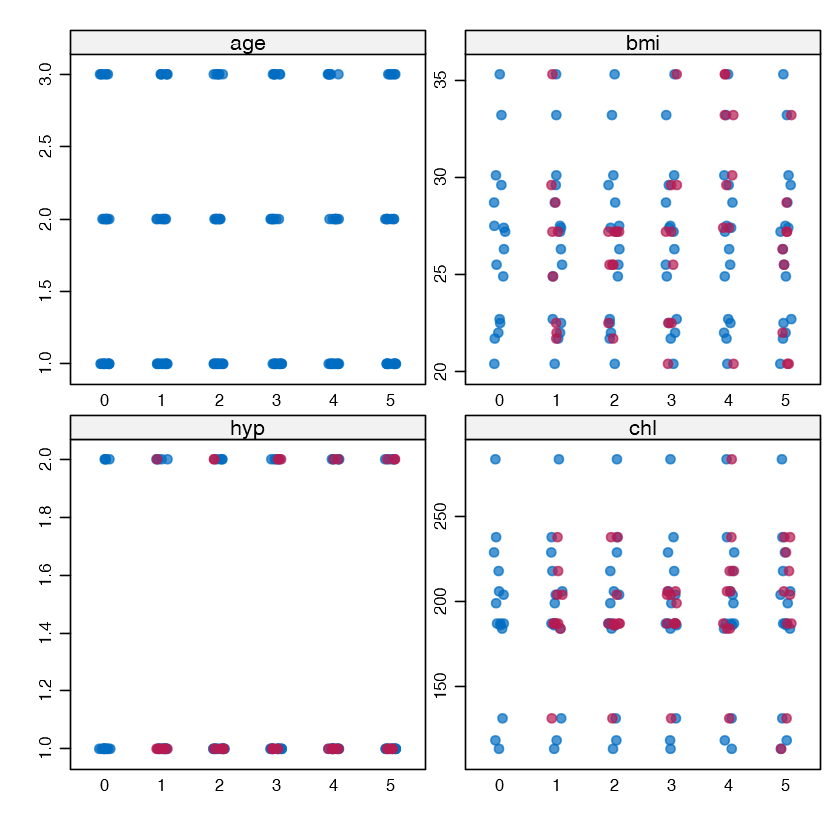

In [9]:
# Visual inspection (big picture)
stripplot(imp, pch = 20, cex = 1.2)

# Colour convention
#   blue    observed
#   red     imputed

# Each x-axis marker is one version of MI. 0 = original set
# Red points follow the blue points reasonably well, including the gaps in the distribution.

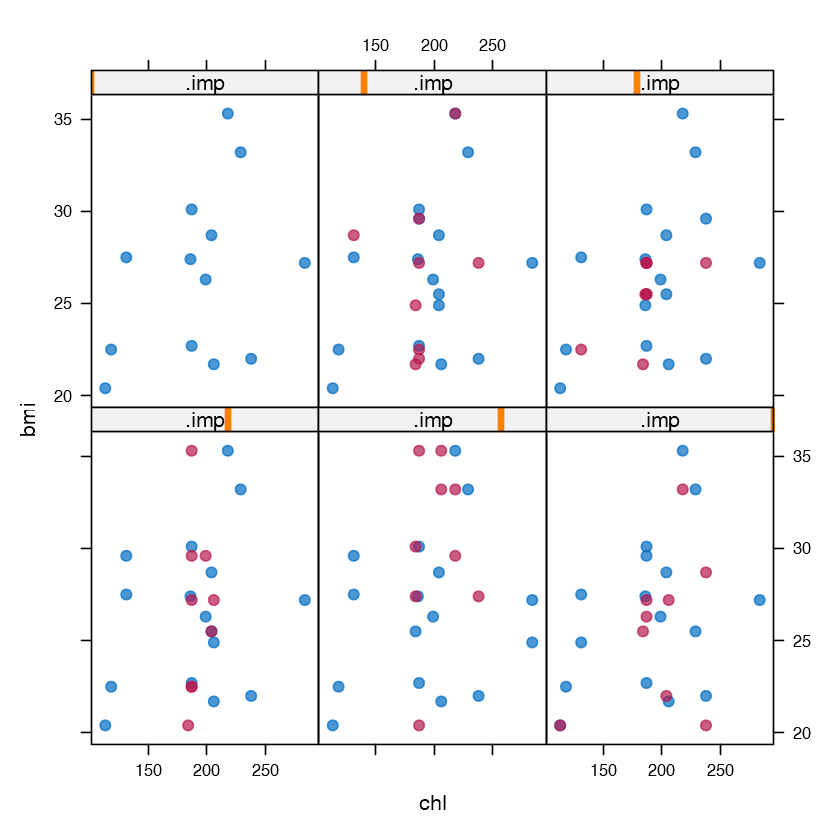

In [10]:
# Visual inspection (fine details)
xyplot(imp, bmi ~ chl | .imp, pch = 20, cex = 1.4)

# Red points have more or less the same shape as blue data => imputed data could have been plausible measurements if they had not been missing
# Differences between the red points represents uncertainty about the true, but unkown, values

### 3.8 Analysing Imputed Datasets

With all the "holes" now being filled, we can apply our familiar analyses to the "restored" datasets. Fortunately, `mice` will automate the analyses for us (`with` function) and pool the results together using Rubin's rule (`pool` function):

In [11]:
# Original regression: lm(chl ~ age + bmi)

# Repeat this analysis to each version of MI
fit <- with(data = imp, exp = lm(chl ~ age + bmi))

# Pool the multiple versions of the analyses together
summary(pool(fit))

# Both age and bmi are significant at .05 level

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.2189968,63.074241,0.003472047,14.80613,0.99727606
age,28.0471913,10.633709,2.637573645,11.58238,0.02223126
bmi,5.3831348,2.126757,2.531146954,11.55051,0.02702526


In [13]:
# If we increase m, the number of imputations, significant levels may change
summary(pool(with(
    mice(nhanes, m = 100, printFlag = F, seed = 23109), # order 10 sets of MI
    lm(chl ~ age + bmi)
))) # More significant

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-14.815838,68.289377,-0.2169567,13.29524,0.83153593
age,33.628336,11.345180,2.9641079,11.70326,0.01211925
bmi,5.597624,2.118558,2.6421863,14.15795,0.01917945


## 4. Fine Tuning `mice`

### 4.1 Specify Imputation Methods

So far, we have been using `mice` as a black box. We now would like to know what default settings `mice` uses and how different types of data are treated:

<img src="./Figures/methods.jpg" style="width:100%">

We are free to specify different imputation methods, depending on our data type, theory and prior practice:

In [14]:
summary(pool(with(
    mice(nhanes,
        method = c("", "norm", "pmm", "mean"), # Specify MI method for each var
        m = 10, print = F, seed = 23109 # printFlag = print = pri
    ),
    lm(chl ~ age + bmi)
)))

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.896819,50.834969,-0.07665627,16.99445,0.939792232
age,31.299527,8.530883,3.66896674,15.88864,0.002095030
bmi,5.237195,1.567365,3.34140136,16.03713,0.004130752


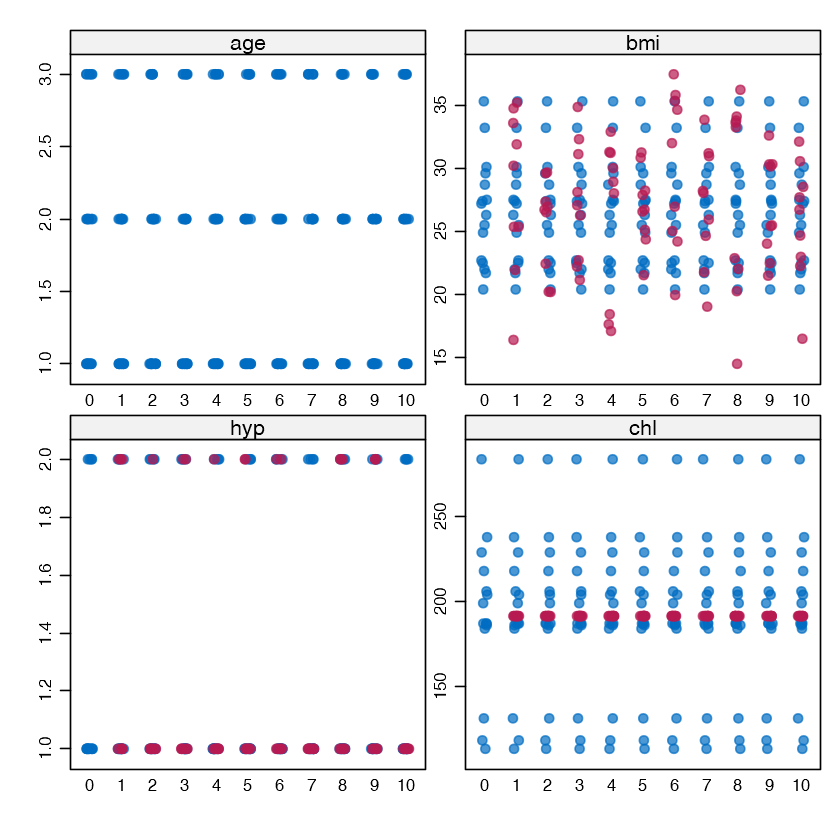

In [15]:

henrik <- mice(nhanes,
        method = c("", "norm", "pmm", "mean"), # Specify MI method for each var
        m = 10, print = F, seed = 23109 # printFlag = print = pri
    )
    stripplot(henrik, pch = 20, cex = 1.2)

We can declare, say, Bayesian linear regression (`norm`), as the default MI method for all variables:

In [16]:
summary(pool(with(
    mice(nhanes,
        method = "norm", # Use norm MI method for all variables
        m = 10, pri = F, seed = 23109
    ),
    lm(chl ~ age + bmi)
)))

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-85.791421,81.186319,-1.056723,6.582155,0.32787166
age,49.978785,13.871964,3.602863,6.436433,0.01004440
bmi,7.244128,2.332117,3.106246,7.787269,0.01501989


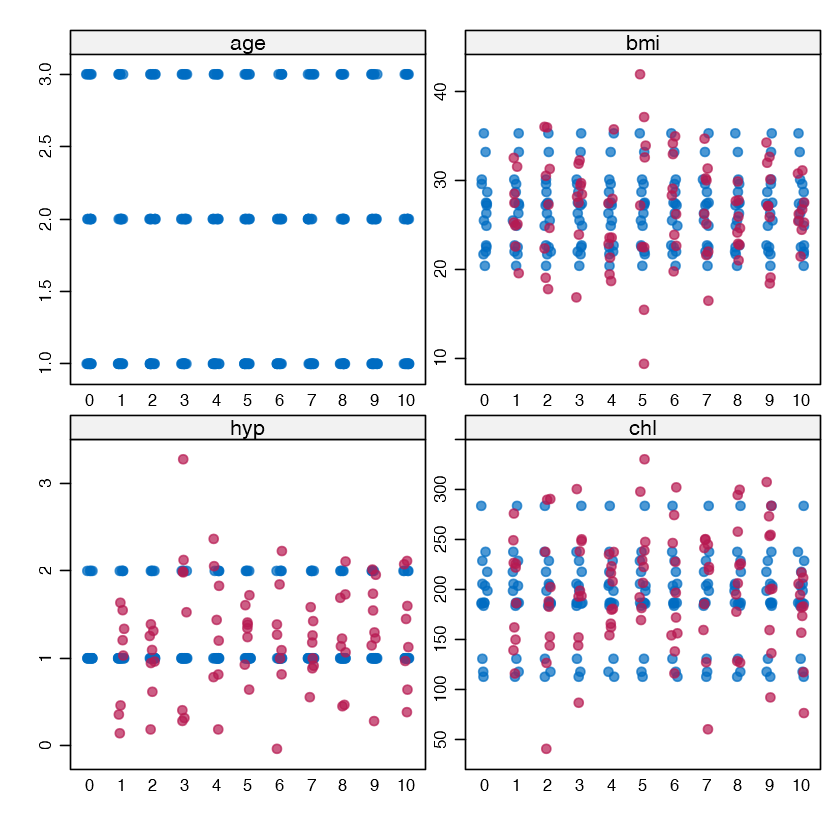

In [17]:
henrik2 <- mice(nhanes,
        method = "norm", # Use norm MI method for all variables
        m = 10, pri = F, seed = 23109
    )
    stripplot(henrik2, pch = 20, cex = 1.2)

If undeclared by the user, `mice` will attempt to determine the most appropriate MI methods based on the data type of each variable:

In [18]:
str(nhanes2)

# Data type
#   age     factor, 3 levels
#   bmi     numeric
#   hyp     factor, 2 levels
#   chl     numeric

'data.frame':	25 obs. of  4 variables:
 $ age: Factor w/ 3 levels "20-39","40-59",..: 1 2 1 3 1 3 1 1 2 2 ...
 $ bmi: num  NA 22.7 NA NA 20.4 NA 22.5 30.1 22 NA ...
 $ hyp: Factor w/ 2 levels "no","yes": NA 1 1 NA 1 NA 1 1 1 NA ...
 $ chl: num  NA 187 187 NA 113 184 118 187 238 NA ...


One sensible set of MI methods could be:

In [ ]:
summary(pool(with(
    mice(nhanes2,
        me = c("polyreg", "pmm", "logreg", "norm"), # me = method
        m = 10, pri = F, seed = 23109
    ),
    lm(chl ~ age + bmi)
)))

### 4.2 Empty Imputation Method

`mice` automatically skips variables containing no missings. If we wish to skip variables with missings, tell `mice` by setting `method = ""` for that variable:

In [ ]:
imp <- mice(nhanes2,
    me = c("", "", "logreg", "norm"), # skip age and bmi
    m = 10, pri = F, seed = 23109
)

### 4.3 Predictor Selection

One of the most useful features of the `mice` algorithm is the ability to specify the set of predictors to be used for each incomplete variable. The default setting of the predictor matrix specifies that all variables predict all others.

In [19]:
imp <- mice(nhanes, pri = F)
imp$predictorMatrix
head(complete(imp))

# Col = predictor; Row = target variable
# bmi is predicted from age, hyp and chl


,age,bmi,hyp,chl
age,0,1,1,1
bmi,1,0,1,1
hyp,1,1,0,1
chl,1,1,1,0


,age,bmi,hyp,chl
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,27.2,1,187
2,2,22.7,1,187
3,1,22.0,1,187
4,3,27.5,2,218
5,1,20.4,1,113
6,3,20.4,1,184


We can tell `mice` not to impute `age` because it is completely observed and to never use `bmi` as a predictor for other target variables because we consider it irrelevant:

In [20]:
pred <- imp$predictorMatrix
pred["age", ] <- 0 # Set age row to zero (remove target)
pred[, "bmi"] <- 0 # Set bmi col to zero (remove predictor)
pred
imp <- mice(nhanes, pred = pred, pri = F)
head(complete(imp))

,age,bmi,hyp,chl
age,0,0,0,0
bmi,1,0,1,1
hyp,1,0,0,1
chl,1,0,1,0


,age,bmi,hyp,chl
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,35.3,1,118
2,2,22.7,1,187
3,1,35.3,1,187
4,3,22.7,1,184
5,1,20.4,1,113
6,3,24.9,1,184


### 4.4 Skipping Imputation

We can skip imputation of, say, `bmi` and leave it as it is. This can be achieved by:
1. eliminating `bmi` from the predictor set (Section 4.3), AND
2. setting the imputation method to "" (Section 4.2)

In [21]:
ini <- mice(nhanes2, maxit = 0, pri = F) # Run an empty MI by setting maxit = 0
# Step 1
pred <- ini$pred
pred[, "bmi"] <- 0
# Step 2
meth <- ini$meth
meth["bmi"] <- ""
# MI
imp <- mice(nhanes2, meth = meth, pred = pred, pri = F)
# Inspect bmi
imp$imp$bmi

,1,2,3,4,5
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,NA,NA,NA,NA,NA
3,NA,NA,NA,NA,NA
4,NA,NA,NA,NA,NA
6,NA,NA,NA,NA,NA
10,NA,NA,NA,NA,NA
11,NA,NA,NA,NA,NA
12,NA,NA,NA,NA,NA
16,NA,NA,NA,NA,NA
21,NA,NA,NA,NA,NA


### 4.5 Intercept-only Imputation (Only if MCAR!)

We can impute, say, `bmi` without using any predictors. Imputation are now sampled by `mice.impute.pmm()` under the intercept-only model. Note that these imputations are appropriate only under the MCAR assumption.

In [ ]:
pred <- ini$pred
pred["bmi", ] <- 0 # Set bmi row to zero (remove target)
imp <- mice(nhanes2, pred = pred, pri = F, seed = 51162)
imp$imp$bmi

### 4.6 Multilevel Imputation

In order to impute hierarchical data, we need to specify the class variable (code `-2`), fixed effect (code `1`) and random effect (code `2`). We use Hox et al.'s (2018) popularity data as an example:

In [22]:
# Inspect original data
head(popmis)

# Extract predictor matrix
suppressWarnings(suppressMessages(
    ini <- mice(popmis, maxit = 0)
))
pred <- ini$pred
# Turn every entry in the predictor matrix to zero
pred <- matrix(0,
    nrow = nrow(pred), ncol = ncol(pred),
    dimnames = list(rownames(pred), colnames(pred))
)
# Assign info to the "popular" row
pred["popular", ] <- c(0, -2, 0, 2, 1, 2, 0)

# MI
suppressWarnings(suppressMessages(
    imp <- mice(popmis,
        meth = c("", "", "2l.norm", "", "", "", ""), # Level-1 normal heteroscedastic
        pred = pred, pri = F, maxit = 1, seed = 71152
    )
))

# Inspect imputed data
head(complete(imp))

,pupil,school,popular,sex,texp,const,teachpop
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,NA,1,24,1,7
2,2,1,NA,0,24,1,7
3,3,1,7,1,24,1,6
4,4,1,NA,1,24,1,6
5,5,1,NA,1,24,1,7
6,6,1,7,0,24,1,7


,pupil,school,popular,sex,texp,const,teachpop
,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,1,1,8.483879,1,24,1,7
2,2,1,7.646901,0,24,1,7
3,3,1,7.000000,1,24,1,6
4,4,1,8.400386,1,24,1,6
5,5,1,7.892165,1,24,1,7
6,6,1,7.000000,0,24,1,7


## 8. Further Readings

The classical guide *Statistical analysis with missing data* has recently been updated to its 3rd edition (Little & Rubin, 2019).

Two alternative textbooks are *Applied missing data analysis* (Enders, 2010) and *Multiple imputation and its application* (Carpenter & Kenward, 2013).

For a step-by-step guide using `mice` for more advanced models such as zero-inflated Poisson, interested readers are referred to Chapter 5 of Kleinke, et al. (2020).

## 9. References

van Buuren, S., & Groothuis-Oudshoorn, K. (2011). `mice`: Multivariate imputation by chained equations in `R`. *Journal of Statistical
Software*, *45*(3), 1–67. <https://doi.org/10.18637/jss.v045.i03>

Carpenter, J. R., & Kenward, M. G. (2013). *Multiple imputation and its application*. Wiley. <https://doi.org/10.1002/9781119942283>

Enders, C. K. (2010). *Applied missing data analysis*. Guilford. <http://hsta559s12.pbworks.com/w/file/fetch/52112520/enders.applied>

Grund, S., Lüdtke, O., & Robitzsch, A. (2018). Multiple imputation of missing data for multilevel models: Simulations and
recommendations. *Organizational Research Methods*, *21*(1), 111–149. <https://doi.org/10.1177/1094428117703686>

Hox, J. J., Moerbeek, M., & van de Schoot, R. (2018). *Multilevel analysis: Techniques and applications* (3rd ed.). Routledge.

Kleinke, K., Reinecke, J., Salfrán, D., & Spiess, M. (2020). *Applied multiple imputation: Advantages, pitfalls, new developments and
applications in `R`*. Springer. <https://doi.org/10.1007/978-3-030-38164-6>

Little, R. J. A., & Rubin, D. B. (2019). *Statistical analysis with missing data* (3rd ed.). Wiley. <https://doi.org/10.1002/9781119482260>

Rose, N. (2013). *Item nonresponses in educational and psychological measurement* [PhD Thesis, Friedrich-Schiller-Universität
Jena]. Open Access Thesis and Dissertations.
<https://www.db-thueringen.de/servlets/MCRFileNodeServlet/dbt_derivate_00027809/Diss/NormanRose.pdf>

Rubin, D. B. (1976). Inference and missing data. *Biometrika*, *63*(3), 581–592. <https://doi.org/10.1093/biomet/63.3.581>

Schafer, J. L. (1997). *Analysis of incomplete multivariate data*. Chapman & Hall; CRC.